# Problem Statement

To predict the house prices in Australia using a combination of factors from the given dataset. The company wants to buy prices at lower prices (than market price) and sell at higher (than the price). In order to achieve the strategy, the company must identify the right price for a house.

In [1073]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [1074]:
# Read Dataset
house = pd.read_csv("C:/Users/Personal/Documents/AIML_Notebooks/ML2/House_Price/train.csv",low_memory= True)

# Basic Sanity Checks

In [1075]:
house.shape == house.drop_duplicates().shape # no duplicates

True

In [1076]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning

**Objective**: Data needs to be cleaned for missing values, formats and any other abnormal value in a series of steps in the data cleaning procedure.

**Step 1**:  Select columns which have meaningful information by removing columns of data which do not have any information

In [1077]:
house = house.loc[:,[x for x in house.columns.tolist() if  house[x].isna().sum() != len(house)]]
print(house.shape) # All 81 remain.

(1460, 81)


**Step2**: Fill mising values

In [1078]:
house.isnull().sum()[house.columns[house.isnull().sum()/len(house) > 0.5]] 

Alley          1369
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

In [1079]:
house_numeric = house.select_dtypes(include=['float64', 'int64'])
house_numeric.isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [1080]:
#NA in Alley column means No Alley, so we will replace NA by it.
house['Alley'].fillna('No Alley', inplace=True)
house['MasVnrType'].fillna('None', inplace=True) 
house['MasVnrType'].fillna('None', inplace=True) 
#NA in FireplaceQu column means No Fireplace, so we will replace NA by it.
house['FireplaceQu'].fillna('No Fireplace', inplace=True)
#NA in PoolQC column means No Pool, so we will replace NA by it.
house['PoolQC'].fillna('No Pool', inplace=True) 
#NA in Fence column means No Fence, so we will replace NA by it.
house['Fence'].fillna('No Fence', inplace=True) 
house['MasVnrArea'].fillna(0, inplace=True) 
house['LotFrontage'].fillna(0, inplace=True) 
#NA in GarageType, GarageFinish, GarageQual, GarageCond columns mean No Garage, so we will replace NA by it.

house['GarageType'].fillna('No Garage', inplace=True) 
house['GarageFinish'].fillna('No Garage', inplace=True) 
house['GarageQual'].fillna('No Garage', inplace=True) 
house['GarageCond'].fillna('No Garage', inplace=True) 
# MiscFeature column has almost 99% null values so we will drop it
house= house.drop('MiscFeature', axis=1)


In [1081]:
house.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

**Step3**: Remove columns with same values for all rows as they will not help in differentiating the loan status


In [1082]:
idx2 = list(np.where([(house[x].nunique() == 1) & (house[x].isnull().sum()==0) for x in house.columns.values.tolist()]))
house = house.drop(house.iloc[:,idx2[0]].columns,axis=1)
house.shape # 0 columns removed

(1460, 80)

**Step 4**: Correct the formats by checking for any incorrect values. To fill, we need to know the datatypes for each column

In [1083]:
house = house.drop(['Id','GarageYrBlt'],axis=1)

In [1084]:
house.MSSubClass =  house.MSSubClass.astype(object)

**Outlier Treatment**:

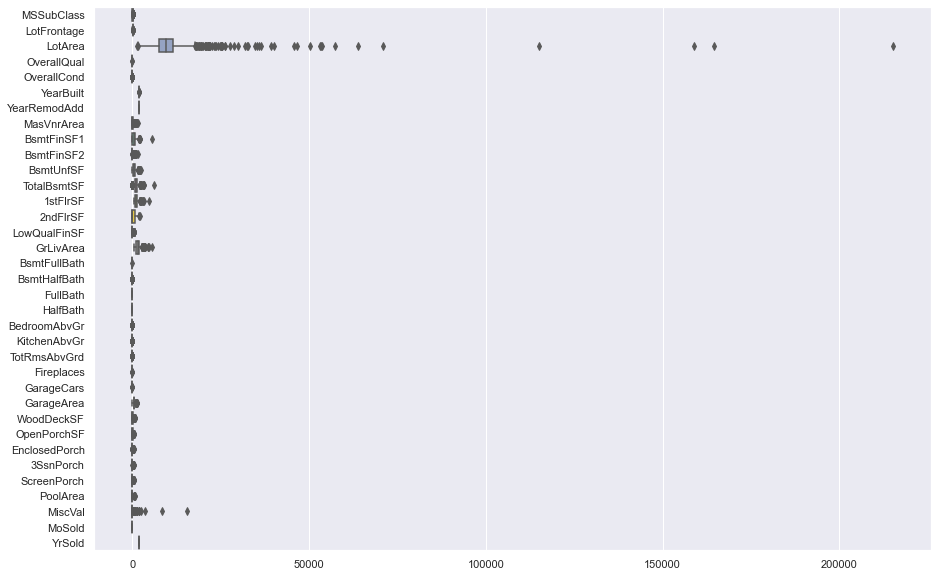

In [1085]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.boxplot(data = house.loc[:, house.columns != 'SalePrice'],orient = "h", palette="Set2")
plt.show()

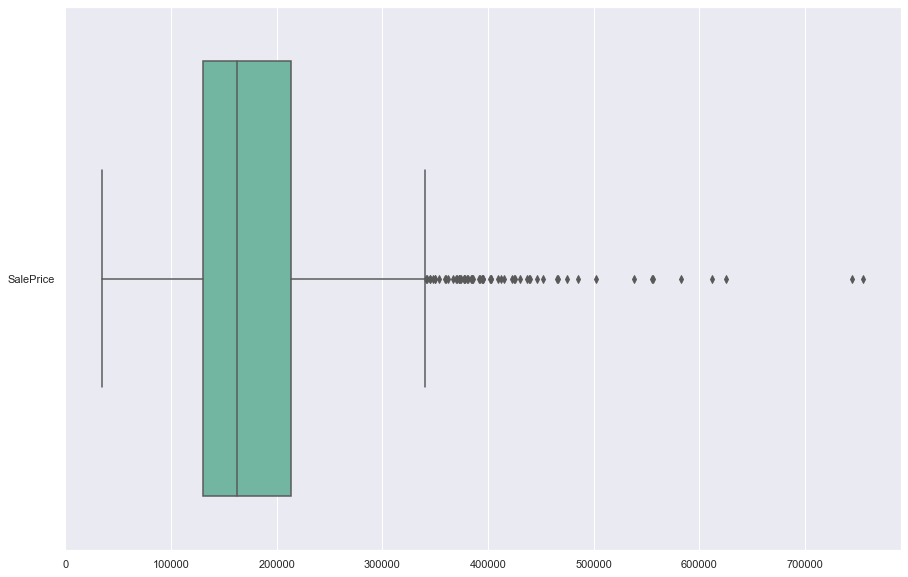

In [1086]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.boxplot(data = house[['SalePrice']],orient = "h", palette="Set2")
plt.show()

Observation: We observe there are many outliers in Lot Area and Sale Price but these are expected. Hence, no outlier removal is recommended.

In [1087]:
house.describe() # checking for format across 36 numeric columns

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Create additional variables based on business understanding: Age variables**

In [1088]:
# Age of property when sold

house['Age'] = house.YrSold - house.YearBuilt

Analyse the relations between numeric variables

In [1089]:
house_numeric = house.select_dtypes(include=['float64', 'int64'])

In [1090]:
house_numeric.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Age
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,61,0,0,0,0,0,2,2008,208500,5
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,0,0,0,5,2007,181500,31
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,42,0,0,0,0,0,9,2008,223500,7
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,35,272,0,0,0,0,2,2006,140000,91
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,84,0,0,0,0,0,12,2008,250000,8


In [1091]:
## Create Dummy values

cat_cols = house.select_dtypes('object')
cat_cols.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [1092]:
cat_cols.shape

(1460, 43)

In [1093]:
# Get the dummy variables for the feature 'furnishingstatus' and store it in a new variable - 'status'

dummied = pd.get_dummies(cat_cols,drop_first= True)
# Check what the dataset 'status' looks like
dummied.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [1094]:
housing = pd.concat([house_numeric, dummied], axis=1)
housing.head() 

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,0,1,0,0,0,1,0


In [1095]:
nacols = housing.isnull().sum()[housing.isnull().sum() != 0].index.values.tolist()
housing[nacols].fillna(0,inplace = True)


In [1096]:
house_numeric = house_numeric.drop(['YrSold','YearBuilt','YearRemodAdd'],axis=1)


# Train Test Split

In [1097]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

housing_train, housing_test = train_test_split(housing, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1098]:
housing_train['log_SP'] = np.log(housing_train.SalePrice)
housing_test['log_SP'] = np.log(housing_test.SalePrice)
y_train = housing_train.pop('log_SP')

y_test = housing_test.pop('log_SP')


In [1099]:
housing_train = housing_train.drop('SalePrice',axis=1)
housing_test = housing_test.drop('SalePrice',axis=1)
house_numeric = house_numeric.drop('SalePrice',axis=1)

In [1100]:
house_numeric.columns.tolist()


['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'Age']

In [1101]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [1102]:
# Apply scaler() to all the columns except the categorical variables
housing_train[house_numeric.columns.tolist()] = scaler.fit_transform(housing_train[house_numeric.columns.tolist()] )

housing_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,0.273876,-0.473765,-0.779861,0.383154,1925,1950,-0.558025,0.043512,-0.293313,-0.374367,...,0,0,0,0,1,0,0,0,1,0
318,0.942770,-0.056845,0.649651,-0.533005,1993,1993,0.809137,1.160345,-0.293313,-0.454644,...,0,0,0,0,1,0,0,0,1,0
239,-0.162360,-0.169324,-0.065105,-1.449164,1945,1950,-0.558025,-0.761296,-0.293313,0.171964,...,0,0,0,0,1,0,0,0,1,0
986,0.041217,-0.502297,-0.065105,2.215472,1910,2003,-0.558025,-0.963574,-0.293313,-0.175904,...,0,0,0,0,1,0,0,0,1,0
1416,0.070299,0.082905,-1.494617,0.383154,1885,1950,-0.558025,-0.963574,-0.293313,0.475233,...,0,0,0,0,1,0,0,0,1,0


In [1103]:
housing_test[house_numeric.columns.tolist()] = scaler.fit_transform(housing_test[house_numeric.columns.tolist()] )


In [1104]:
# housing_train.isnull().sum()[housing_train.isnull().sum()!=0]
# housing_train.fillna(0,inplace = True)
# housing_train.isnull().sum()[housing_train.isnull().sum()!=0]
# housing.isnull().sum()
# housing_train = housing_train.drop('GarageYrBlt',axis=1)
# housing_est = housing_test.drop('GarageYrBlt',axis=1)

In [1105]:
# housing_test.fillna(0,inplace = True)

## Dividing into X and Y sets for the model building

In [1106]:
housing_train = housing_train.drop(['YrSold','YearBuilt','YearRemodAdd'],axis=1)
housing_test = housing_test.drop(['YrSold','YearBuilt','YearRemodAdd'],axis=1)

In [1107]:
X_train = housing_train
X_test = housing_test

## Building the model

### RFE

In [1108]:
from sklearn.feature_selection import RFE

In [1109]:
X_train.columns[rfe.ranking_]

Index(['SaleType_ConLw', 'Condition1_RRAn', 'LotArea', 'Neighborhood_Blueste',
       'GarageQual_Po', 'Fence_MnPrv', 'Electrical_FuseP', 'MSSubClass_120',
       'MSZoning_RH', 'MSZoning_RM',
       ...
       'Functional_Sev', 'FireplaceQu_Po', 'MSSubClass_160',
       'Neighborhood_MeadowV', 'HouseStyle_SFoyer', 'Condition1_RRNe',
       'Exterior1st_Stone', 'HeatingQC_Po', 'LotShape_Reg', 'MSSubClass_75'],
      dtype='object', length=263)

In [1111]:
# Ridge

# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge(fit_intercept = True)

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge,
                        
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1112]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.1}


In [1113]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 0.1
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.58903820e-03  2.84368914e-02  5.25984132e-02  4.26543061e-02
  2.75477737e-03  2.37619526e-02  1.07302467e-02  5.07229838e-03
  3.30114443e-02  4.87482058e-02  4.67596402e-02  1.61134258e-03
  7.48741724e-02  1.47089080e-02  1.24708967e-03  1.07330557e-02
  5.71113539e-03  5.27584318e-03 -1.77838589e-02  2.21376230e-03
 -1.43590526e-03  2.41445220e-02  1.68878729e-02  1.01002713e-02
  4.81668689e-03  6.94566420e-03  5.58473595e-03  8.12996710e-03
  1.38184416e-02  1.18591591e-03  7.48981055e-04 -6.47958418e-02
 -7.40326190e-02 -1.14990592e-01 -2.17415609e-01  7.21587256e-03
 -5.43134811e-02  9.48957896e-03 -3.86586202e-02 -3.23856990e-02
  9.59593671e-03 -9.93177051e-03 -3.30525236e-02 -1.51013083e-01
 -6.84556074e-02 -3.60692804e-02  4.24085573e-01  4.11031332e-01
  4.10943705e-01  3.58336782e-01  1.02379647e-01  2.02155372e-02
  5.00479304e-02  1.61440445e-02 -1.56080242e-03  1.08933307e-02
  2.14253675e-02  1.05942009e-02  3.69137429e-02 -1.55428384e-01
  2.90536470e-02 -4.53999

In [1114]:
from sklearn.metrics import r2_score, mean_squared_error

In [1115]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9586177789270011
0.7512185915517096
6.641525451334836
17.929320608004875
0.006504922087497391
0.04093452193608419


In [1116]:
## Lasso

lasso = Lasso(fit_intercept=True)

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1117]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [1118]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [1119]:
lasso.coef_

array([ 1.33843856e-03,  2.24737784e-02,  5.60110016e-02,  4.87576031e-02,
        3.85884830e-03,  2.28986734e-02,  1.11098978e-02, -0.00000000e+00,
        4.31359138e-02,  7.80496907e-02,  8.11222235e-02,  1.85215174e-03,
        3.34723692e-02,  1.51573317e-02, -0.00000000e+00,  1.13652132e-02,
        7.40814416e-03,  2.44311634e-03, -1.89202737e-02,  3.33852348e-03,
        4.80878605e-04,  2.21807927e-02,  1.73367082e-02,  1.04232243e-02,
        7.43368343e-03,  5.23352098e-03,  5.26630833e-03,  6.74364362e-03,
        2.58942934e-03, -5.30535458e-04, -1.76015120e-03, -6.68368658e-02,
       -6.56822335e-02, -8.90943570e-03, -6.65201766e-03,  1.07759282e-02,
       -1.25777648e-02,  4.31186258e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -1.95026623e-02, -9.26500192e-02,
       -2.34108450e-02, -3.78203403e-02,  3.27502006e-01,  3.27107561e-01,
        3.18552918e-01,  2.67000776e-01,  6.73654591e-02,  6.09176742e-03,
        3.04304048e-02,  

In [1120]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9552664302846752
0.6791438560900441
7.179390909668746
23.123643800760387
0.007031724691154501
0.05279370730767212


## Check important coefficients

In [1121]:
model_parameters = list(ridge.coef_ )
# model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
model_parameters.sort(reverse= True)
cols = housing_train.columns
# cols = cols.insert(0, "Intercept")
list(zip(cols, model_parameters))

[('LotFrontage', 0.447),
 ('LotArea', 0.424),
 ('OverallQual', 0.411),
 ('OverallCond', 0.411),
 ('MasVnrArea', 0.358),
 ('BsmtFinSF1', 0.301),
 ('BsmtFinSF2', 0.3),
 ('BsmtUnfSF', 0.288),
 ('TotalBsmtSF', 0.268),
 ('1stFlrSF', 0.265),
 ('2ndFlrSF', 0.26),
 ('LowQualFinSF', 0.249),
 ('GrLivArea', 0.242),
 ('BsmtFullBath', 0.238),
 ('BsmtHalfBath', 0.235),
 ('FullBath', 0.22),
 ('HalfBath', 0.198),
 ('BedroomAbvGr', 0.195),
 ('KitchenAbvGr', 0.191),
 ('TotRmsAbvGrd', 0.181),
 ('Fireplaces', 0.179),
 ('GarageCars', 0.151),
 ('GarageArea', 0.151),
 ('WoodDeckSF', 0.147),
 ('OpenPorchSF', 0.134),
 ('EnclosedPorch', 0.129),
 ('3SsnPorch', 0.122),
 ('ScreenPorch', 0.115),
 ('PoolArea', 0.113),
 ('MiscVal', 0.111),
 ('MoSold', 0.102),
 ('Age', 0.098),
 ('MSSubClass_30', 0.097),
 ('MSSubClass_40', 0.097),
 ('MSSubClass_45', 0.095),
 ('MSSubClass_50', 0.094),
 ('MSSubClass_60', 0.091),
 ('MSSubClass_70', 0.091),
 ('MSSubClass_75', 0.09),
 ('MSSubClass_80', 0.086),
 ('MSSubClass_85', 0.086),
 ('

In [1122]:
# For subjective questions

#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha2 = 0.2
ridge2 = Ridge(alpha=alpha2)

ridge2.fit(X_train, y_train)
print(ridge2.coef_)

[-2.96282163e-03  2.58307478e-02  5.49261796e-02  4.23138934e-02
  2.06537711e-03  1.94278453e-02  1.11324476e-02  5.08987799e-03
  2.87894433e-02  4.62778652e-02  4.72675664e-02  2.25322287e-03
  7.34998302e-02  1.68151532e-02  1.52240457e-03  1.21779156e-02
  6.61714968e-03  5.82332339e-03 -1.77539879e-02  3.64958002e-03
 -1.93066146e-03  2.79506747e-02  1.36487909e-02  1.02400657e-02
  4.17207293e-03  7.10962186e-03  5.99853300e-03  8.61815005e-03
  7.90525767e-03  6.45313216e-04  5.76575080e-04 -6.14862768e-02
 -7.29914468e-02 -1.05461918e-01 -1.82780702e-01  1.27541669e-02
 -5.62406566e-02  1.31270933e-02  3.67228953e-03 -2.45545148e-02
  1.35196705e-02 -6.21865825e-03 -3.62525868e-02 -1.44371286e-01
 -6.51739008e-02 -3.21846395e-02  3.74277118e-01  3.67580685e-01
  3.67444591e-01  3.20542651e-01  1.00161303e-01  1.69005518e-02
  4.88961035e-02  1.75830904e-02 -1.36998448e-02  1.12265796e-02
  3.08401862e-02  2.21188223e-02  4.39324948e-02 -1.42907345e-01
  3.05098613e-02 -4.81799

In [1123]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge2.predict(X_train)
y_pred_test = ridge2.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9565143123429617
0.7897501642619504
6.979115520009164
15.152405222882145
0.006835568579832678
0.03459453247233366


In [1125]:
## lasso subjective

#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha2 =0.0002

lasso2 = Lasso(alpha=alpha2)
        
lasso2.fit(X_train, y_train) 

Lasso(alpha=0.0002)

In [1126]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso2.predict(X_train)
y_pred_test = lasso2.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9511173321474159
0.7093792280272863
7.845288973237722
20.94462375040255
0.007683926516393459
0.04781877568585057


In [1127]:
model_parameters = list(ridge2.coef_ )
# model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
model_parameters.sort(reverse= True)
cols = housing_train.columns
# cols = cols.insert(0, "Intercept")
list(zip(cols, model_parameters))

[('LotFrontage', 0.374),
 ('LotArea', 0.368),
 ('OverallQual', 0.367),
 ('OverallCond', 0.328),
 ('MasVnrArea', 0.321),
 ('BsmtFinSF1', 0.283),
 ('BsmtFinSF2', 0.257),
 ('BsmtUnfSF', 0.248),
 ('TotalBsmtSF', 0.224),
 ('1stFlrSF', 0.222),
 ('2ndFlrSF', 0.21),
 ('LowQualFinSF', 0.207),
 ('GrLivArea', 0.206),
 ('BsmtFullBath', 0.194),
 ('BsmtHalfBath', 0.183),
 ('FullBath', 0.177),
 ('HalfBath', 0.173),
 ('BedroomAbvGr', 0.172),
 ('KitchenAbvGr', 0.171),
 ('TotRmsAbvGrd', 0.17),
 ('Fireplaces', 0.143),
 ('GarageCars', 0.14),
 ('GarageArea', 0.133),
 ('WoodDeckSF', 0.13),
 ('OpenPorchSF', 0.12),
 ('EnclosedPorch', 0.115),
 ('3SsnPorch', 0.114),
 ('ScreenPorch', 0.113),
 ('PoolArea', 0.112),
 ('MiscVal', 0.101),
 ('MoSold', 0.1),
 ('Age', 0.098),
 ('MSSubClass_30', 0.097),
 ('MSSubClass_40', 0.096),
 ('MSSubClass_45', 0.092),
 ('MSSubClass_50', 0.091),
 ('MSSubClass_60', 0.088),
 ('MSSubClass_70', 0.082),
 ('MSSubClass_75', 0.081),
 ('MSSubClass_80', 0.08),
 ('MSSubClass_85', 0.08),
 ('MSSu